Based on:

- [PyMC3 and Bayesian Inference Towards Non-Linear Models: Part 1](https://medium.com/towards-data-science/pymc3-and-bayesian-inference-for-parameter-uncertainty-quantification-towards-non-linear-models-d1d50250f16a)
- [PyMC3 and Bayesian inference for Parameter Uncertainty Quantification Towards Non-Linear Models: Part 2](https://towardsdatascience.com/pymc3-and-bayesian-inference-for-parameter-uncertainty-quantification-towards-non-linear-models-a03c3303e6fa)


In [1]:
import autograd.numpy as np
from autograd import grad
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as optimize
import arviz as az
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on Arviz v{}'.format(az.__version__))

# %matplotlib qt

Running on PyMC3 v3.11.5
Running on Arviz v0.12.1


### Newton's Cooling Law

$$
\dfrac{d T(t)}{dt} = - \dfrac{1}{\tau} \left( T(t) - T_{env} \right)
$$

### Solution

$$
T(t) = T_{env} + \left( T_0 - T_{env} \right) e^{- \frac{t}{\tau} }
$$

### Initial conditions
We assume that environment temperature is $T_{env}=30^\circ C$ and the object starts to cool off at $T_0=100^\circ C$. Finally, to generate a synthetic dataset we assume that the time constant $\tau = 15$.

# Data

In [2]:
def newton_cooling(tau, T_0, T_env, time):
    Temp = T_env + (T_0 - T_env) * np.exp(-time / tau)
    return Temp

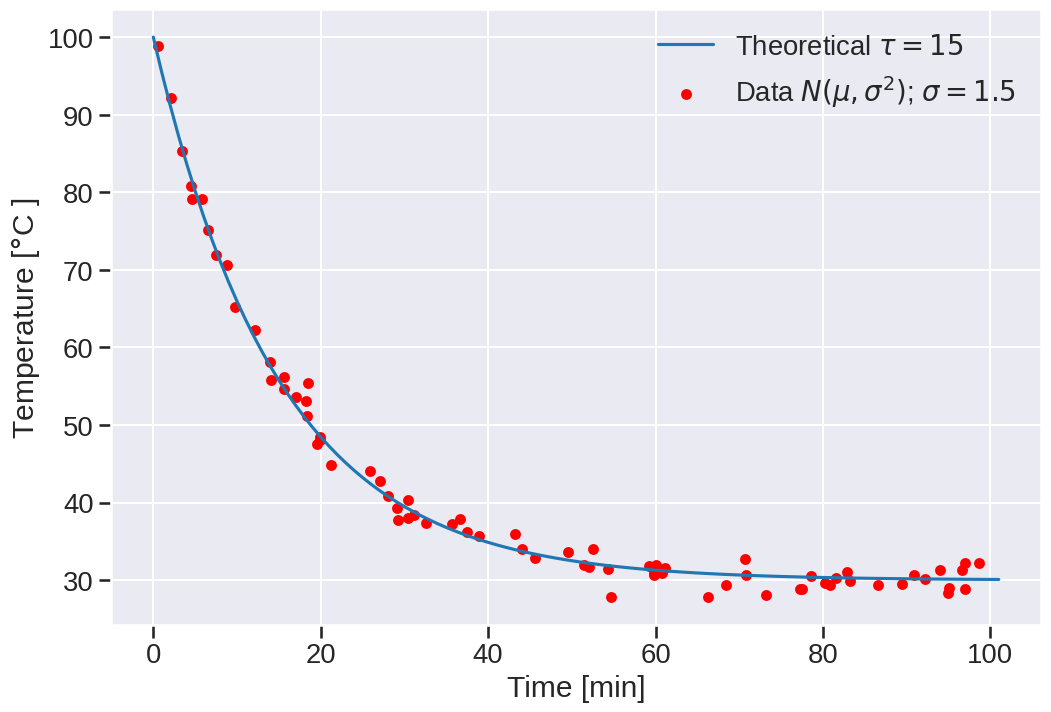

In [3]:
np.random.seed(42) 

# Intial Conditions and Parameters
T_env, T_0 = 30, 100
tau = 15

# Theortical Result
time = np.arange(0, 102)
T_theory = newton_cooling(tau, T_0, T_env, time)  # perfect or ideal model response

# Artificial Data and Noise
time_data = np.random.rand(75) * 100
time_data.sort()
sigma_noise = 1.5  # standard deviation
T_data = newton_cooling(tau, T_0, T_env, time_data)
T_data = np.random.normal(T_data, scale=sigma_noise)

with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12, 8))
    plt.plot(time, T_theory)
    plt.scatter(time_data, T_data, c='r',s=40 )
    plt.ylabel(r'Temperature [$\degree$C ]')
    plt.xlabel('Time [min]')
    plt.legend([r'Theoretical $\tau=15$', r'Data $N(\mu, \sigma^2)$; $\sigma=1.5$'])

# Estimating $\tau$

In [4]:
def sum_squares(tau, T_0, T_env, time, data):
    return np.sum((data - newton_cooling(tau,T_0, T_env, time))**2)

In [5]:
optimized_result = optimize.minimize(sum_squares, x0=10, args=(T_0, T_env, time_data, T_data), tol=1e-5)

# Optional Method Below:
# tau_opt = optimize.curve_fit(lambda time, tau : T_env + (T_0 - T_env) * np.exp(-time / tau), time_data, T_data)
# print(tau_opt)

print(optimized_result)
tau_opt = optimized_result.x[0]  # optimized parameter
ss_min = optimized_result.fun  # best sum of squares using optimal tau parameter

      fun: 152.8082171764478
 hess_inv: array([[0.00690039]])
      jac: array([5.7220459e-06])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([15.14557946])


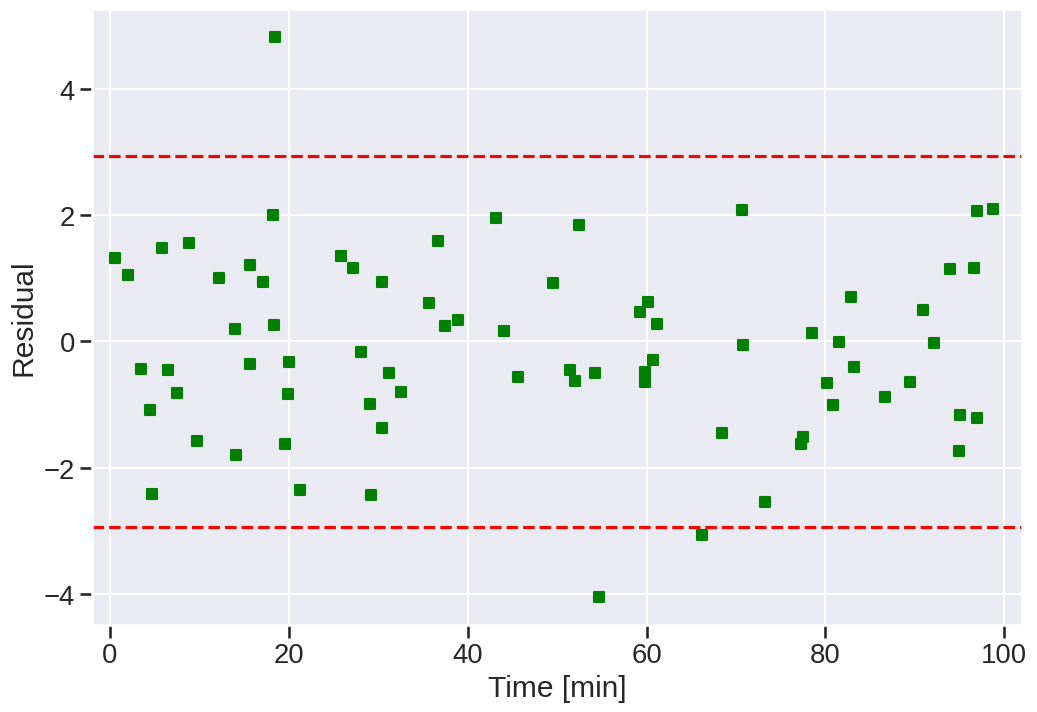

In [6]:
residuals = T_data - newton_cooling(tau_opt, T_0, T_env, time_data)

with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12,8 ))
    plt.scatter(time_data, residuals, s=50, c='g', marker="s")
    plt.hlines(sigma_noise*1.96, -2, 102, linestyle='dashed', colors='r')
    plt.hlines(sigma_noise*-1.96, -2, 102, linestyle='dashed', colors='r')
    plt.xlabel('Time [min]')
    plt.ylabel('Residual')
    plt.xlim([-2, 102])

In [7]:
sigma_error_square = (1/(len(time_data)-1))*ss_min
print(f"Actual standard deviation of the noise: {sigma_noise}")
print(f"Estimated standard deviation of the noise: {np.sqrt(sigma_error_square):0.2f}")
# sigma_error_square = (1/(len(time_data)-1))* np.transpose(residuals)@residuals       Equivalent method

Actual standard deviation of the noise: 1.5
Estimated standard deviation of the noise: 1.44


# Estmating $\tau$ and $\sigma$

In [8]:
# model expected value of the response is normally distributed with mean being the nonlinear function with unknown parameter and sd unknown with the data acting as our observations 

with pm.Model() as model_g:
    tau = pm.Uniform('τ', 0, 100)
    eps = pm.HalfNormal('ϵ', sigma=5)
#     nu = pm.Exponential('ν', 1/30)
#     eps = pm.Uniform('ϵ', 0, 5)
#     mu = pm.Deterministic('μ', newton_cooling(tau, T_0, T_env, time_data))
#     T_pred = pm.StudentT('T_pred', mu=mu, sd=eps, nu=nu, observed=T_data)
#      epsilon = pm.Normal('eps', mu=0, sd=ϵ, observed=T_data - μ)
    T_pred = pm.Normal('T_pred', mu=newton_cooling(tau, T_0, T_env, time_data), sd=eps, observed=T_data)

    trace_g = pm.sample(2000, tune=2000, cores=4)

/home/pawel/Development/bayesian-regression/venv/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, τ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [9]:
az.summary(trace_g)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/pawel/Development/bayesian-regression/venv/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
τ,15.145,0.174,14.816,15.463,0.002,0.001,6895.0,5298.0,1.0
ϵ,1.461,0.126,1.227,1.695,0.002,0.001,6655.0,5199.0,1.0


In [10]:
chain_count = trace_g.get_values('τ').shape[0]
y_pred_g = pm.sample_posterior_predictive(trace_g, samples=chain_count, model=model_g)
data_spp = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/pawel/Development/bayesian-regression/venv/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Text(0, 0.5, '$\\epsilon$')

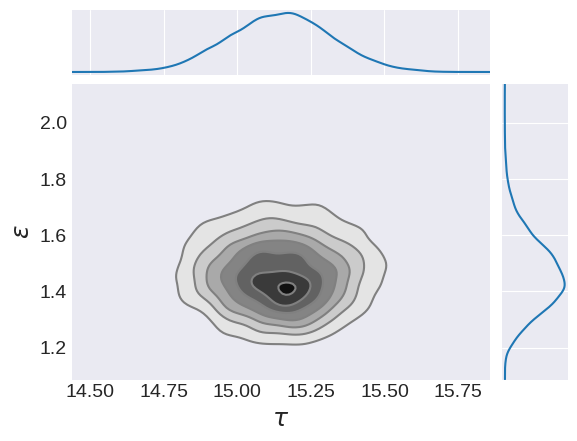

In [29]:
pair_plot = az.plot_pair(data_spp, var_names=['τ', 'ϵ'], kind='kde', marginals=True, fill_last=False)
pair_plot[1][0].set_xlabel(r'$\tau$', fontsize=18)
pair_plot[1][0].set_ylabel(r'$\epsilon$', fontsize=18)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/pawel/Development/bayesian-regression/venv/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/tmp/ipykernel_482408/73250045.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  trace_fig[i][j].set_xticklabels(x_labels, fontsize=14)
/tmp/ipykernel_482408/73250045.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  trace_fig[i][j].set_yticklabels(y_labels, fontsize=14)
/tmp/ipykernel_482408/73250045.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  trace_fig[i]

Text(0.5, 1.0, '$\\epsilon$')

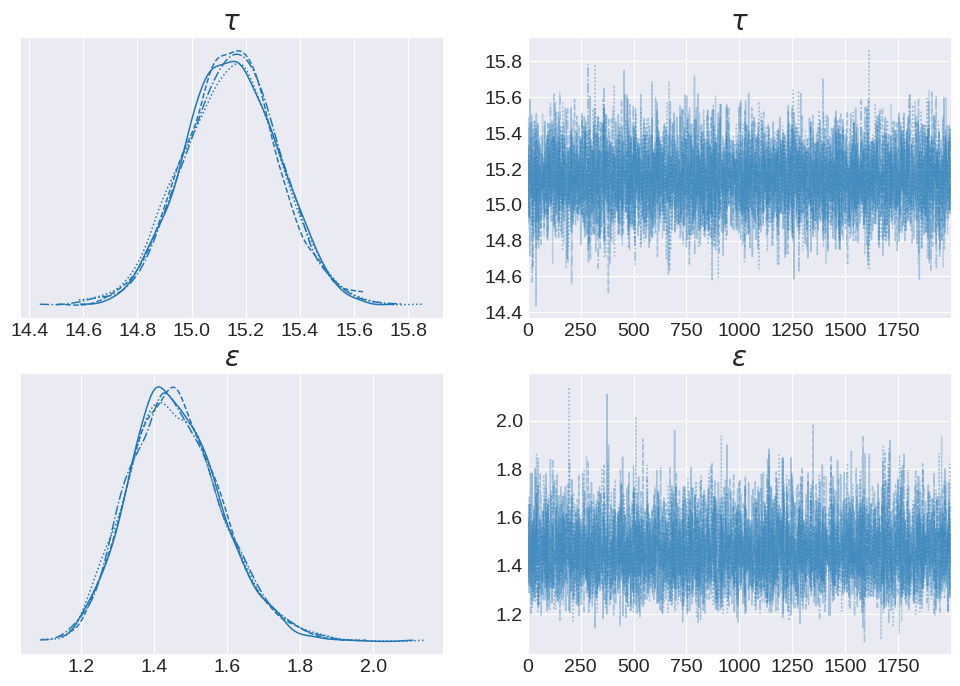

In [28]:
trace_fig = az.plot_trace(trace_g, var_names=['τ', 'ϵ'], figsize=(12, 8))

# get and change x labels
for i in range(trace_fig.shape[0]):
    for j in range(trace_fig.shape[1]):
        if j==0:
            x_labels = [str(np.round(x,3)) for x in trace_fig[i][j].get_xticks()]
            trace_fig[i][j].set_xticklabels(x_labels, fontsize=14)
            
        if j==1:
            y_labels = [str(np.round(y,3)) for y in trace_fig[i][j].get_yticks()]
            trace_fig[i][j].set_yticklabels(y_labels, fontsize=14)

            x_labels = [str(int(x)) for x in trace_fig[i][j].get_xticks()]
            trace_fig[i][j].set_xticklabels(x_labels, fontsize=14)

        title=trace_fig[i][j].get_title()
        trace_fig[i][j].set_title(title, fontsize=20)

trace_fig[0][0].set_title(r'$\tau$', fontsize=20)
trace_fig[0][1].set_title(r'$\tau$', fontsize=20)

trace_fig[1][0].set_title(r'$\epsilon$', fontsize=20)
trace_fig[1][1].set_title(r'$\epsilon$', fontsize=20)

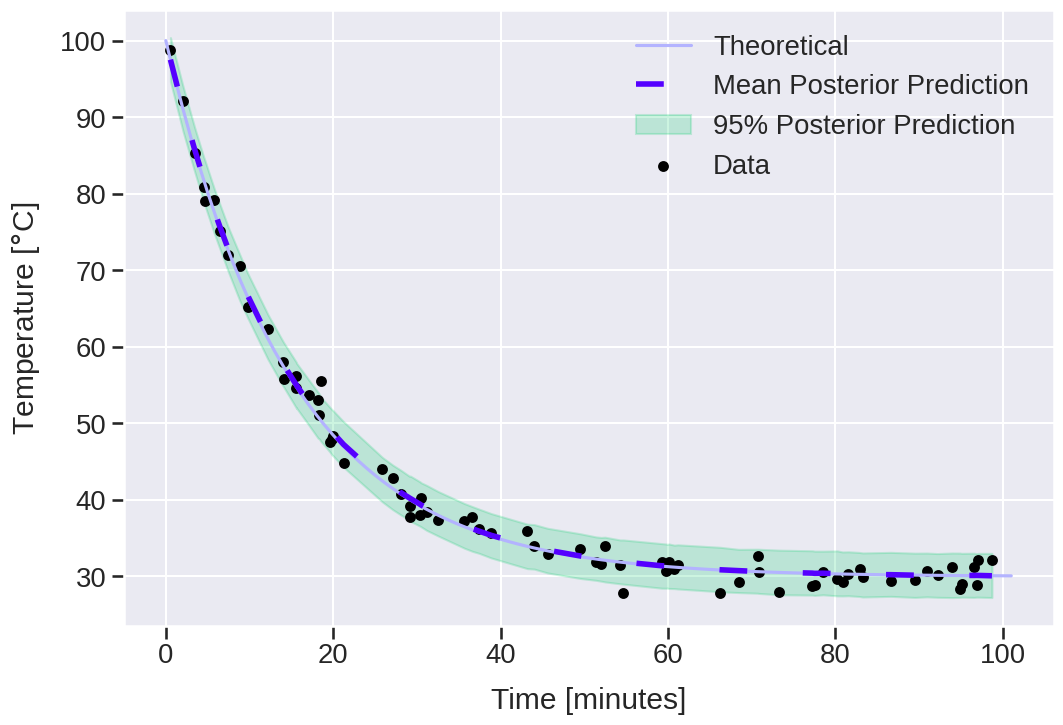

In [21]:
crit_l = np.percentile(y_pred_g["T_pred"],q=2.5,axis=0)  # grab lower 2.5% quantiles
crit_u = np.percentile(y_pred_g["T_pred"],q=97.5,axis=0)  # grab Upper 92.5% quantiles
mean_spp = np.mean(y_pred_g["T_pred"], axis=0) # Median

with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12, 8))
    plt.plot(time, T_theory, color='#b3b3ff')
    plt.plot(time_data, mean_spp, linestyle='--', dashes=(5, 10), linewidth=4, color="#5500ff")
    plt.fill_between(time_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
    plt.scatter(time_data, T_data, c='k', s=40)
    plt.legend(['Theoretical', 'Mean Posterior Prediction', '95% Posterior Prediction', 'Data'])
    plt.xlabel('Time [minutes]', labelpad=13)
    plt.ylabel(r'Temperature [$\degree$C]', labelpad=13)
#     for prediction in ppc["T_pred"]:
#         plt.plot(time_data, prediction, alpha=0.4)

Text(0.5, 1.0, '$\\epsilon$')

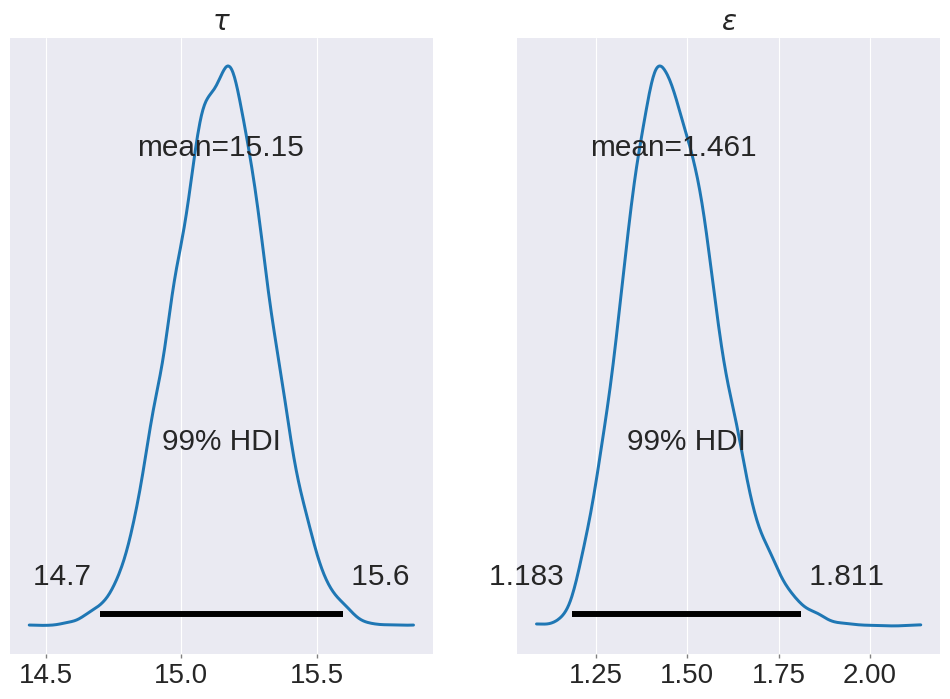

In [22]:
posterior_plot = pm.plot_posterior(data_spp,
                                     point_estimate='mean',
                                     hdi_prob=0.99,
                                     textsize=20,
                                     round_to=4, figsize=(12, 8))
posterior_plot[0].set_title(r'$\tau$', fontsize=20)
posterior_plot[1].set_title(r'$\epsilon$', fontsize=20)

In [23]:
grad_newton = grad(newton_cooling, 0) # differentiate the 0th parameter
grad_newton_values = [grad_newton(tau_opt,T_0, T_env, time) for time in time_data]
grad_newton_values= np.asarray(grad_newton_values)

delta_k = 1 / (np.transpose(grad_newton_values)@grad_newton_values)
t_inv = stats.t.ppf(1-0.05/2, len(time_data)-1)


tau_freq_LB, tau_freq_UB = tau_opt - t_inv*np.sqrt(sigma_error_square)*np.sqrt(delta_k), tau_opt + t_inv*np.sqrt(sigma_error_square)*np.sqrt(delta_k)

print(tau_freq_LB, tau_freq_UB)

14.808280446230633 15.482878467534874


In [24]:
CI = []
PI = []
S_xx = np.sum((time_data-np.mean(time_data))**2)
x_mean = np.mean(time_data)
n=len(time_data)
for i in range(0, n):
    CI.append(t_inv * np.sqrt(sigma_error_square) * np.sqrt(1/n + ((time_data[i]-x_mean)**2 / ((n-1)*S_xx))))
    PI.append(t_inv * np.sqrt(sigma_error_square) * np.sqrt(1 + 1/n + ((time_data[i]-x_mean)**2 / ((n-1)*S_xx))))

T_expected = newton_cooling(tau_opt, T_0, T_env,time_data)

# Compare Frequentist and Bayesian

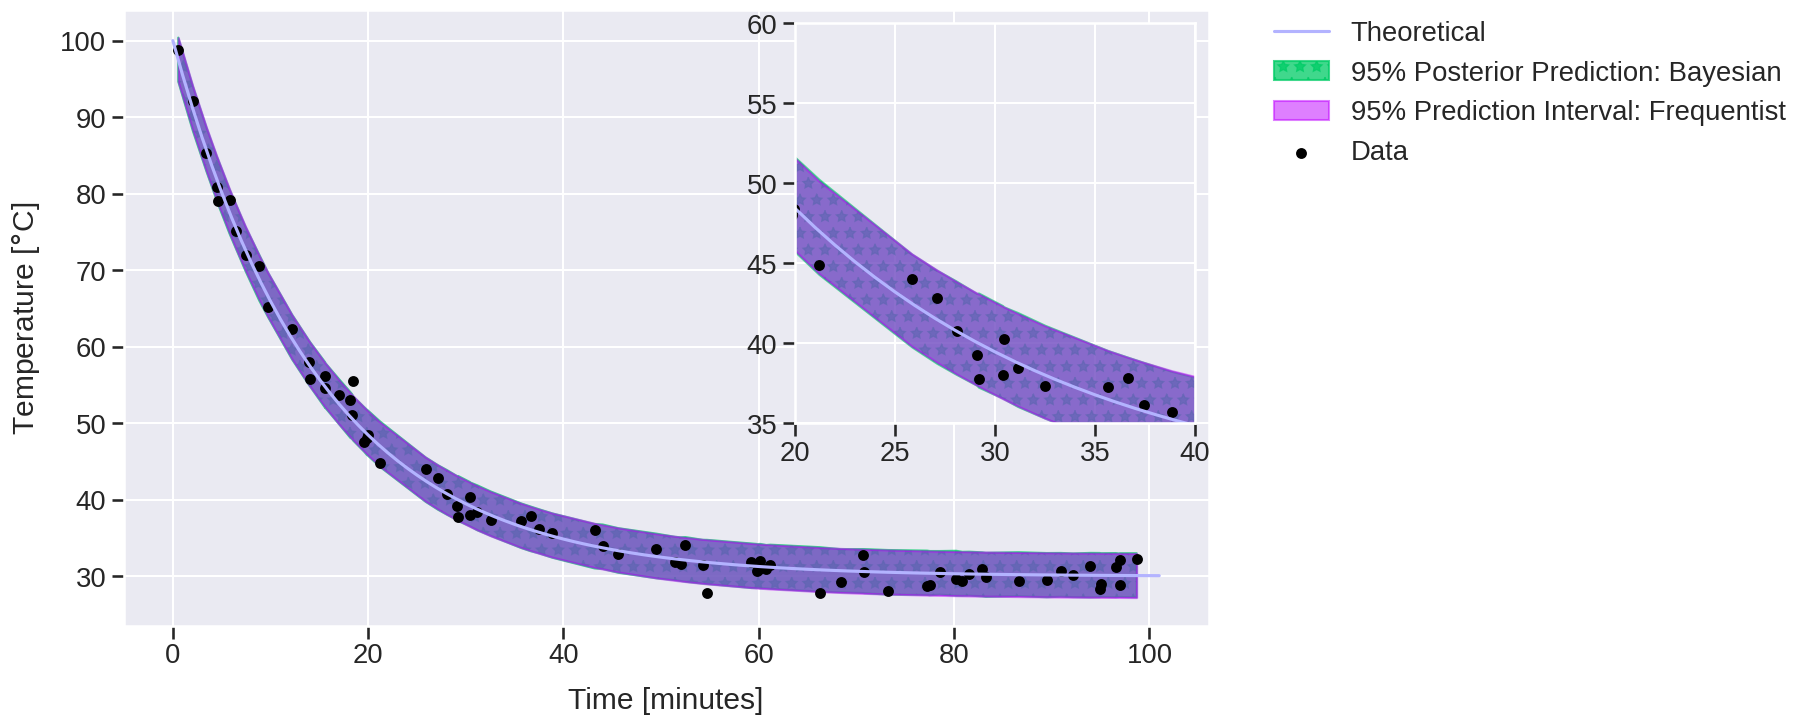

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,8))
    plt.plot(time, T_theory, color='#b3b3ff')
    plt.fill_between(time_data, crit_l, crit_u, alpha=0.75, hatch="*", color= "#00cc66")
    plt.fill_between(time_data, T_expected + PI , T_expected - PI, alpha=0.5, color='#bf00ff')
    plt.scatter(time_data, T_data, c='k',s=40)
#     plt.legend()
    plt.xlabel('Time [minutes]', labelpad=13)
    plt.ylabel(r'Temperature [$\degree$C]', labelpad=13)
    plt.legend(['Theoretical', '95% Posterior Prediction: Bayesian', '95% Prediction Interval: Frequentist', 'Data'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    axins = inset_axes(ax, width=4, height=4)
    axins.plot(time, T_theory, color='#b3b3ff')
    axins.fill_between(time_data, crit_l, crit_u, alpha=0.65, hatch="*", color= "#00cc66")
    axins.fill_between(time_data, T_expected + PI , T_expected - PI, alpha=0.5, color='#bf00ff')
    axins.set_xticks([20, 25, 30, 35, 40])
    axins.scatter(time_data, T_data, c='k',s=40)
    plt.xlim([20, 40])
    plt.ylim([35, 60])

# Supplementary Plots

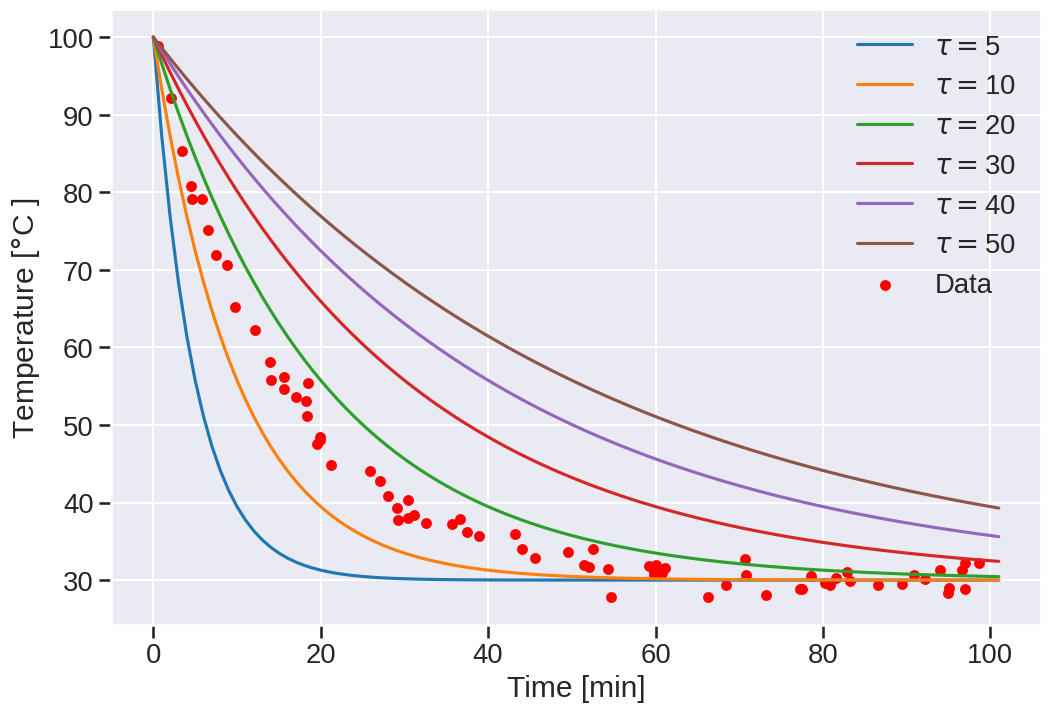

In [26]:
# Prior for τ
tau = [5, 10 ,20, 30, 40 ,50]
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12, 8))
    leg_labels = []
    for val in tau:
        plt.plot(time, newton_cooling(val, 100, 30, time))
        plt.ylabel(r'Temperature [$\degree$C ]')
        plt.xlabel('Time [min]')
        leg_labels.append(r"$\tau=$" + str(val))
   
    plt.scatter(time_data, T_data, c='r', s=40 )
    leg_labels.append('Data')
    plt.legend(leg_labels)

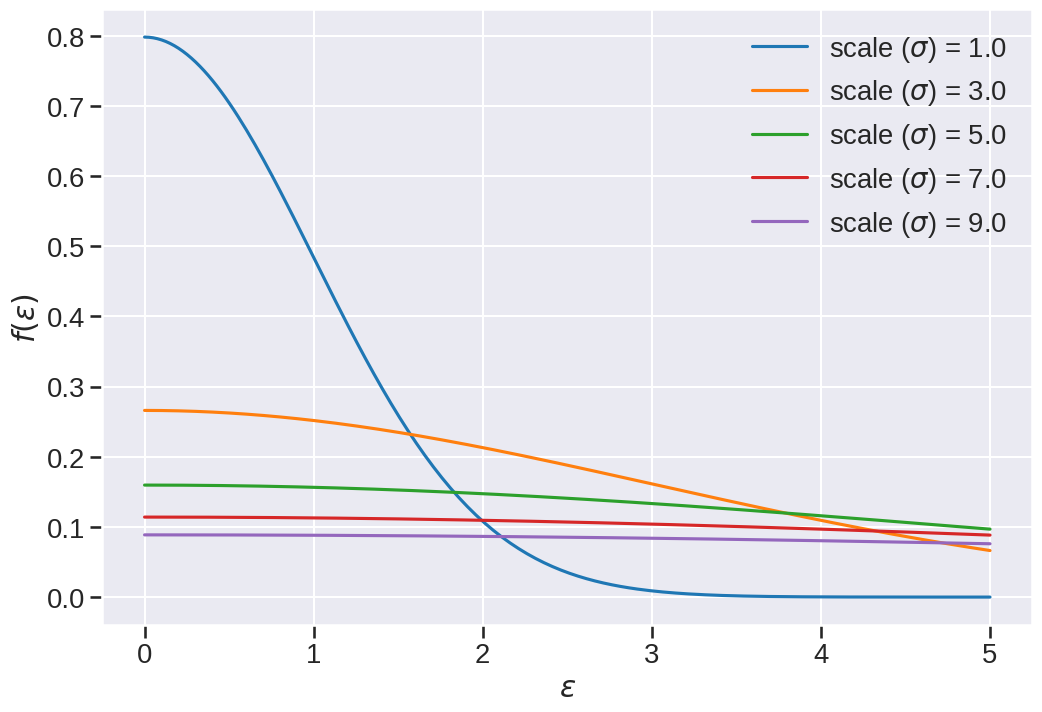

In [27]:
# Prior for ϵ
x = np.linspace(0, 5, 200)
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12, 8))
    for sigma in [1., 3., 5., 7., 9.0]:
        pdf = stats.halfnorm.pdf(x, scale=sigma)
        plt.plot(x, pdf, label=r'scale ($\sigma$) = {}'.format(sigma))
    plt.xlabel(r'$\epsilon$')
    plt.ylabel(r'$f(\epsilon)$')
    plt.legend(loc=1)
    plt.show()